# Customer Churn Prediction Model

<u>Data Source:</u><br>
https://www.kaggle.com/olistbr/brazilian-ecommerce

<u>Notes for Order_Items:</u><br>
The `total order_item value` is: `21.33 * 3 = 63.99`<br>
The `total freight value` is: `15.10 * 3 = 45.30`<br>
The `total order value (product + freight)` is: `45.30 + 63.99 = 109.29`<br>

In [97]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Data Transformation

In [35]:
# import the data
customers = pd.read_csv('data/olist_customers_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
orderitems = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')

In [36]:
# data size
print(customers.shape)
print(orders.shape)
print(orderitems.shape)
print(products.shape)

(99441, 5)
(99441, 8)
(112650, 7)
(32951, 9)


In [120]:
# check dtypes
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [121]:
customers['customer_zip_code_prefix']=customers['customer_zip_code_prefix'].astype('object')

In [122]:
# check dtypes
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [123]:
# convert date columsn to datetime
date_columns=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date'\
              ,'order_delivered_customer_date','order_estimated_delivery_date']
# df['Date']= pd.to_datetime(df['Date'])
for col in date_columns:
    orders[col]=pd.to_datetime(orders[col])

In [5]:
# preview customers
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
# preview orders
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
# preview orderitems
orderitems.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [8]:
# preview products
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [124]:
# look for nulls
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [125]:
# look for nulls
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

We should remove `order_id`s where the `order_delivered_customer_date` is null assuming it means that these orders were cancelled and never fulfilled.

In [126]:
# look for nulls
orderitems.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [127]:
# look for nulls
products.isna().sum()

product_id                      0
product_category_name           0
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [128]:
# observe rows with null product_category_name
products.query('product_category_name!=product_category_name')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


Since we only plan to use the `product_category_name` column, let's replace those NaNs with value `Unknown`

In [129]:
products['product_category_name']=products['product_category_name'].fillna('Unknown')

In [130]:
# we should expect to see no more results in query below
products.query('product_category_name!=product_category_name')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


## Aggregate the Order_Items table to Order level

In [132]:
# create new dataframe at order level with total price and freight_value
order_totalvalues=orderitems[['order_id', 'price','freight_value']].groupby('order_id').sum().reset_index()
order_numitems=orderitems[['order_id','order_item_id']].groupby('order_id').count().reset_index()

In [133]:
# create a new column called order_value = price + freight_value
order_totalvalues['order_value']=order_totalvalues['price']+order_totalvalues['freight_value']

# create a new column that is the ratio of freight_value to order_value (freight_value/order_value)
order_totalvalues['freight_ratio']= order_totalvalues['freight_value']/order_totalvalues['order_value']

In [134]:
# merge order_totalvalues and order_numitems
orderdetails=pd.merge(order_totalvalues, order_numitems, on='order_id', how='inner')

In [135]:
orderdetails.head()

,order_id,price,freight_value,order_value,freight_ratio,order_item_id
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,72.19,0.184098,1
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,259.83,0.076704,1
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,216.87,0.082400,1
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,25.78,0.496121,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,218.04,0.083196,1


In [136]:
# view the final ordervalues dataframe
orderdetails.rename(columns={'order_item_id':'num_items'},inplace=True)
orderdetails.head()

,order_id,price,freight_value,order_value,freight_ratio,num_items
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,72.19,0.184098,1
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,259.83,0.076704,1
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,216.87,0.082400,1
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,25.78,0.496121,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,218.04,0.083196,1


In [137]:
# join the orderdetails dataframe to the orders
orders_final=pd.merge(orders, orderdetails, how='inner', on='order_id')

In [138]:
orders_final.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,price,freight_value,order_value,freight_ratio,num_items
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,8.72,38.71,0.225265,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,22.76,141.46,0.160894,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,19.22,179.12,0.107302,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,45.00,27.20,72.20,0.376731,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,19.90,8.72,28.62,0.304682,1


In [139]:
orders_final['order_status'].value_counts()

delivered      96478
shipped         1106
canceled         461
invoiced         312
processing       301
unavailable        6
approved           2
Name: order_status, dtype: int64

Remove all non-delivered orders.

In [140]:
orders_final=orders_final.query('order_status=="delivered"')

In [141]:
orders_final.shape

(96478, 13)

In [142]:
orders_final.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
price                                   float64
freight_value                           float64
order_value                             float64
freight_ratio                           float64
num_items                                 int64
dtype: object

## Customer Profile Function

In [191]:
# dedupe the customer table to customer_unique_id
customers_deduped=customers.drop_duplicates(subset='customer_unique_id', keep='last')

In [192]:
print(customers.shape)
print(customers_deduped.shape)

(99441, 5)
(96096, 5)


In [143]:
orders_final['order_approved_at'].min()

Timestamp('2016-09-15 12:16:38')

In [144]:
orders_final['order_approved_at'].max()

Timestamp('2018-08-29 15:10:26')

In [199]:
def generate_customer_profile(start_date, end_date):
    # subset orders by date range
    orders_subset=orders_final[(orders_final['order_approved_at']<=end_date) & (orders_final['order_approved_at']>=start_date)]
    
    # join orders to customers
    orders_subset_customers=pd.merge(customers,orders_subset, on='customer_id', how='inner')
    
    # create customer-level order attributes
    first_order_date=orders_subset_customers.groupby('customer_unique_id')['order_approved_at'].min().reset_index()
    last_order_date=orders_subset_customers.groupby('customer_unique_id')['order_approved_at'].max().reset_index()
    num_orders=orders_subset_customers.groupby('customer_unique_id')['order_id'].count().reset_index()
    num_orderdays=orders_subset_customers.groupby('customer_unique_id')['order_approved_at'].count().reset_index()
    num_items=orders_subset_customers.groupby('customer_unique_id')['num_items'].sum().reset_index()
    total_price=orders_subset_customers.groupby('customer_unique_id')['price'].sum().reset_index()
    total_freight=orders_subset_customers.groupby('customer_unique_id')['freight_value'].sum().reset_index()
    total_ordervalue=orders_subset_customers.groupby('customer_unique_id')['order_value'].sum().reset_index()
    avg_freight_ratio=orders_subset_customers.groupby('customer_unique_id')['freight_ratio'].mean().reset_index()
    avg_item_price=orders_subset_customers.groupby('customer_unique_id')['price'].mean().reset_index()
    avg_order_value=orders_subset_customers.groupby('customer_unique_id')['order_value'].mean().reset_index()

    # rename columns
    first_order_date.rename(columns={'order_approved_at':'first_order_date'}, inplace=True)
    last_order_date.rename(columns={'order_approved_at':'last_order_date'}, inplace=True)
    num_orders.rename(columns={'order_id':'num_orders'}, inplace=True)
    num_orderdays.rename(columns={'order_approved_at':'num_order_days'}, inplace=True)
    num_items.rename(columns={'num_items':'total_num_items'}, inplace=True)
    total_price.rename(columns={'price':'total_price'}, inplace=True)
    total_freight.rename(columns={'freight_value':'total_freight'}, inplace=True)
    total_ordervalue.rename(columns={'order_value':'total_order_value'}, inplace=True)
    avg_freight_ratio.rename(columns={'freight_ratio':'avg_freight_ratio'}, inplace=True)
    avg_item_price.rename(columns={'price':'avg_item_price'}, inplace=True)
    avg_order_value.rename(columns={'order_value':'avg_order_value'}, inplace=True)
    
    # merge all the customer-level attributes to the customer table to create a customer_profile dataframe
    aggregated_attributes=[first_order_date,last_order_date,num_orders,num_orderdays,num_items,total_price,\
                      total_freight,total_ordervalue,avg_freight_ratio,avg_item_price,avg_order_value]

    customer_profiles=pd.DataFrame()
    
    # NEED TO DEDUPE THE CUSTOMERS TABLE
    for i, attribute in enumerate(aggregated_attributes):
        if i==0:
            customer_profiles=pd.merge(customers_deduped,attribute, on='customer_unique_id', how='inner')
        elif i<len(attribute)-1:
            customer_profiles=pd.merge(customer_profiles, attribute, on='customer_unique_id', how='inner')
    
    # return the final profiles dataframe
    return customer_profiles

In [200]:
# create a base customer profile
start_date_base=orders_final['order_approved_at'].min()
end_date_base='2017-08-29 23:59:59'
customer_profiles_base=generate_customer_profile(start_date_base,end_date_base)

In [201]:
customer_profiles_base.shape

(21283, 16)

In [202]:
print(customer_profiles_base['first_order_date'].min())
print(customer_profiles_base['last_order_date'].max())

2016-09-15 12:16:38
2017-08-29 23:44:42


In [226]:
# create 1YR forward customer profile
start_date_1YR='2017-08-30 00:00:00'
end_date_1YR=orders_final['order_approved_at'].max()
customer_profiles_1YR=generate_customer_profile(start_date_1YR,end_date_1YR)

In [227]:
customer_profiles_1YR.shape

(72612, 16)

In [228]:
print(customer_profiles_1YR['first_order_date'].min())
print(customer_profiles_1YR['last_order_date'].max())

2017-08-30 00:04:21
2018-08-29 15:10:26


In [229]:
customer_profiles_base.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,first_order_date,last_order_date,num_orders,num_order_days,total_num_items,total_price,total_freight,total_order_value,avg_freight_ratio,avg_item_price,avg_order_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,2017-05-16 15:22:12,2017-05-16 15:22:12,1,1,1,124.99,21.88,146.87,0.148975,124.99,146.87
1,9b8ce803689b3562defaad4613ef426f,7f3a72e8f988c6e735ba118d54f47458,5416,sao paulo,SP,2017-05-13 11:55:16,2017-05-13 11:55:16,1,1,1,89.90,12.13,102.03,0.118887,89.90,102.03
2,154c4ded6991bdfa3cd249d11abf4130,e607ede0e63436308660236f5a52da5e,88034,florianopolis,SC,2017-08-13 10:24:04,2017-08-13 10:24:04,1,1,1,105.00,18.00,123.00,0.146341,105.00,123.00
3,237098a64674ae89babdc426746260fc,4390ddbb6276a66ff1736a6710205dca,82820,curitiba,PR,2017-04-14 11:35:23,2017-04-14 11:35:23,1,1,1,79.90,14.73,94.63,0.155659,79.90,94.63
4,6e359a57a91f84095cc64e1b351aef8c,2e6a42a9b5cbb0da62988694f18ee295,4571,sao paulo,SP,2017-05-15 18:10:18,2017-05-15 18:10:18,1,1,1,29.99,17.60,47.59,0.369826,29.99,47.59


In [230]:
customer_profiles_1YR.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,first_order_date,last_order_date,num_orders,num_order_days,total_num_items,total_price,total_freight,total_order_value,avg_freight_ratio,avg_item_price,avg_order_value
0,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,2018-01-12 20:58:32,2018-01-12 20:58:32,1,1,1,289.00,46.48,335.48,0.138548,289.00,335.48
1,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,2018-05-20 16:19:10,2018-05-20 16:19:10,1,1,1,139.94,17.79,157.73,0.112788,139.94,157.73
2,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,2018-03-13 17:29:19,2018-03-13 17:29:19,1,1,1,149.94,23.36,173.30,0.134795,149.94,173.30
3,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,2018-07-29 10:10:09,2018-07-29 10:10:09,1,1,1,230.00,22.25,252.25,0.088206,230.00,252.25
4,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP,2018-02-19 14:50:37,2018-02-19 14:50:37,1,1,1,14.99,7.78,22.77,0.341678,14.99,22.77


In [231]:
# see how many customers actually made a future purchase
customer_profiles_base_1YR=pd.merge(customer_profiles_base,customer_profiles_1YR,on='customer_unique_id',how='inner')
print(customer_profiles_base_1YR.shape)

(550, 31)


In [232]:
# summary: customer_profiles_base
customer_profiles_base.describe()

,num_orders,num_order_days,total_num_items,total_price,total_freight,total_order_value,avg_freight_ratio,avg_item_price,avg_order_value
count,21283.000000,21283.000000,21283.000000,21283.000000,21283.000000,21283.000000,21283.000000,21283.000000,21283.000000
mean,1.027628,1.027628,1.165907,139.499922,22.396122,161.896043,0.210889,136.181563,157.966048
std,0.180810,0.180810,0.571920,223.662149,20.057880,232.501207,0.126847,215.619120,223.897078
min,1.000000,1.000000,1.000000,3.900000,0.000000,12.280000,0.000000,3.900000,12.280000
25%,1.000000,1.000000,1.000000,45.490000,14.110000,61.460000,0.118887,45.000000,60.860000
50%,1.000000,1.000000,1.000000,86.800000,16.790000,104.700000,0.183411,84.900000,102.120000
75%,1.000000,1.000000,1.000000,150.000000,24.840000,177.345000,0.278158,149.700000,171.850000
max,6.000000,6.000000,21.000000,7388.000000,1002.290000,7571.630000,0.851621,6735.000000,6929.310000


In [260]:
# add column with snapshot date
customer_profiles_base['snapshot_date'] = '2017-08-29 23:59:59'
customer_profiles_base['snapshot_date']=pd.to_datetime(customer_profiles_base['snapshot_date'])

In [261]:
# add days since first & last orders
customer_profiles_base['days_since_last_order']=(customer_profiles_base['snapshot_date'] - customer_profiles_base['last_order_date']).dt.days
customer_profiles_base['days_since_first_order']=(customer_profiles_base['snapshot_date'] - customer_profiles_base['first_order_date']).dt.days

In [262]:
customer_profiles_base[['first_order_date', 'last_order_date','days_since_last_order','days_since_first_order']].head()

,first_order_date,last_order_date,days_since_last_order,days_since_first_order
0,2017-05-16 15:22:12,2017-05-16 15:22:12,105,105
1,2017-05-13 11:55:16,2017-05-13 11:55:16,108,108
2,2017-08-13 10:24:04,2017-08-13 10:24:04,16,16
3,2017-04-14 11:35:23,2017-04-14 11:35:23,137,137
4,2017-05-15 18:10:18,2017-05-15 18:10:18,106,106


In [264]:
# set days since cols as ints
customer_profiles_base['days_since_last_order'] = customer_profiles_base['days_since_last_order'].astype('int')
customer_profiles_base['days_since_first_order'] = customer_profiles_base['days_since_first_order'].astype('int')

In [265]:
# summary: customer_profiles_1YR
customer_profiles_1YR.describe()

,num_orders,num_order_days,total_num_items,total_price,total_freight,total_order_value,avg_freight_ratio,avg_item_price,avg_order_value
count,72612.000000,72612.000000,72612.000000,72612.000000,72612.000000,72612.000000,72612.000000,72612.000000,72612.000000
mean,1.027282,1.027282,1.175673,141.172958,23.705928,164.878886,0.208051,137.790730,160.856340
std,0.186033,0.186033,0.616228,211.995505,23.270513,222.946167,0.124471,207.831256,217.939699
min,1.000000,1.000000,1.000000,0.850000,0.000000,9.590000,0.000000,0.850000,9.590000
25%,1.000000,1.000000,1.000000,47.900000,13.880000,63.130000,0.116382,46.990000,62.650000
50%,1.000000,1.000000,1.000000,89.800000,17.670000,108.200000,0.183256,88.000000,106.500000
75%,1.000000,1.000000,1.000000,152.000000,25.520000,182.320000,0.274278,149.900000,177.490000
max,11.000000,11.000000,24.000000,13440.000000,1794.960000,13664.080000,0.955451,13440.000000,13664.080000


## Data Exploration

In [266]:
# combine the base and 1YR dataframes
df = pd.merge(customer_profiles_base, customer_profiles_1YR, how='left', on='customer_unique_id',suffixes=('','_1YR'))

In [267]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,first_order_date,last_order_date,num_orders,num_order_days,total_num_items,total_price,total_freight,total_order_value,avg_freight_ratio,avg_item_price,avg_order_value,snapshot_date,days_since_last_order,days_since_first_order,customer_id_1YR,customer_zip_code_prefix_1YR,customer_city_1YR,customer_state_1YR,first_order_date_1YR,last_order_date_1YR,num_orders_1YR,num_order_days_1YR,total_num_items_1YR,total_price_1YR,total_freight_1YR,total_order_value_1YR,avg_freight_ratio_1YR,avg_item_price_1YR,avg_order_value_1YR
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,2017-05-16 15:22:12,2017-05-16 15:22:12,1,1,1,124.99,21.88,146.87,0.148975,124.99,146.87,2017-08-29 23:59:59,105,105,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9b8ce803689b3562defaad4613ef426f,7f3a72e8f988c6e735ba118d54f47458,5416,sao paulo,SP,2017-05-13 11:55:16,2017-05-13 11:55:16,1,1,1,89.90,12.13,102.03,0.118887,89.90,102.03,2017-08-29 23:59:59,108,108,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,154c4ded6991bdfa3cd249d11abf4130,e607ede0e63436308660236f5a52da5e,88034,florianopolis,SC,2017-08-13 10:24:04,2017-08-13 10:24:04,1,1,1,105.00,18.00,123.00,0.146341,105.00,123.00,2017-08-29 23:59:59,16,16,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,237098a64674ae89babdc426746260fc,4390ddbb6276a66ff1736a6710205dca,82820,curitiba,PR,2017-04-14 11:35:23,2017-04-14 11:35:23,1,1,1,79.90,14.73,94.63,0.155659,79.90,94.63,2017-08-29 23:59:59,137,137,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6e359a57a91f84095cc64e1b351aef8c,2e6a42a9b5cbb0da62988694f18ee295,4571,sao paulo,SP,2017-05-15 18:10:18,2017-05-15 18:10:18,1,1,1,29.99,17.60,47.59,0.369826,29.99,47.59,2017-08-29 23:59:59,106,106,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [268]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'first_order_date',
       'last_order_date', 'num_orders', 'num_order_days', 'total_num_items',
       'total_price', 'total_freight', 'total_order_value',
       'avg_freight_ratio', 'avg_item_price', 'avg_order_value',
       'snapshot_date', 'days_since_last_order', 'days_since_first_order',
       'customer_id_1YR', 'customer_zip_code_prefix_1YR', 'customer_city_1YR',
       'customer_state_1YR', 'first_order_date_1YR', 'last_order_date_1YR',
       'num_orders_1YR', 'num_order_days_1YR', 'total_num_items_1YR',
       'total_price_1YR', 'total_freight_1YR', 'total_order_value_1YR',
       'avg_freight_ratio_1YR', 'avg_item_price_1YR', 'avg_order_value_1YR'],
      dtype='object')

In [269]:
df.drop(columns=['customer_id_1YR', 'customer_zip_code_prefix_1YR', 'customer_city_1YR',\
       'customer_state_1YR', 'first_order_date_1YR', 'last_order_date_1YR',\
       'num_orders_1YR', 'num_order_days_1YR', 'total_num_items_1YR',\
       'total_price_1YR', 'total_freight_1YR',\
       'avg_freight_ratio_1YR', 'avg_item_price_1YR', 'avg_order_value_1YR'], inplace=True)

In [270]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'first_order_date',
       'last_order_date', 'num_orders', 'num_order_days', 'total_num_items',
       'total_price', 'total_freight', 'total_order_value',
       'avg_freight_ratio', 'avg_item_price', 'avg_order_value',
       'snapshot_date', 'days_since_last_order', 'days_since_first_order',
       'total_order_value_1YR'],
      dtype='object')

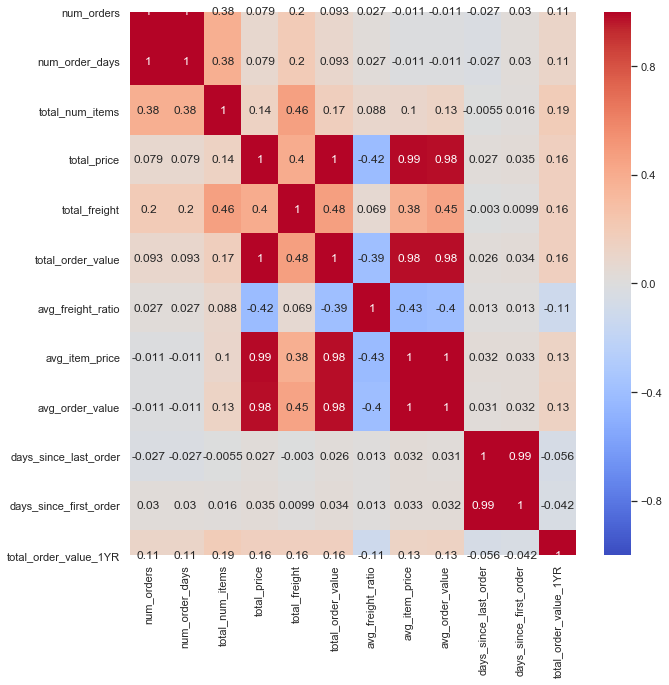

In [272]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.corr(),cmap='coolwarm',vmin=-1, vmax=1, annot=True, ax=ax)